# Testing selection strategies for EvoGFuzz

We use this notebook (work in progress) to test our selection strategies and compare them to the default tournament selection.

## Setup for the calculator

As a proof of concept, we use the calculator from `evogfuzz_demo.ipynb` to measure the performance of all 4 strategies. First, we set up the calculator:

In [1]:
import math
from debugging_framework.input.oracle import OracleResult

def calculator(inp: str) -> float:
    """
        A simple calculator function that can evaluate arithmetic expressions 
        and perform basic trigonometric functions and square root calculations.
    """
    return eval(
        str(inp), {"sqrt": math.sqrt, "sin": math.sin, "cos": math.cos, "tan": math.tan}
    )

In [2]:
# Make sure you use the OracleResult from the debugging_framework library
from debugging_framework.input.oracle import OracleResult

def oracle(inp: str):
    """
    This function serves as an oracle or intermediary that catches and handles exceptions 
    generated by the 'calculator' function. The oracle function is used in the context of fuzz testing.
    It aims to determine whether an input triggers a bug in the 'calculator' function.

    Args:
        inp (str): The input string to be passed to the 'calculator' function.

    Returns:
        OracleResult: An enumerated type 'OracleResult' indicating the outcome of the function execution.
            - OracleResult.PASSING: Returned if the calculator function executes without any exception or only with CalculatorSyntaxError
            - OracleResult.FAILING: Returned if the calculator function raises a ValueError exception, indicating a potential bug.
    """
    try:
        calculator(inp)
    except ValueError as e:
        return OracleResult.FAILING
    
    return OracleResult.PASSING

In [3]:
initial_inputs = ['sqrt(1)', 'cos(912)', 'tan(4)']

for inp in initial_inputs:
    print(inp.ljust(20), oracle(inp))

sqrt(1)              PASSING
cos(912)             PASSING
tan(4)               PASSING


In [4]:
from debugging_framework.types import Grammar
from debugging_framework.fuzzingbook.grammar import is_valid_grammar

CALCGRAMMAR: Grammar = {
    "<start>":
        ["<function>(<term>)"],

    "<function>":
        ["sqrt", "tan", "cos", "sin"],
    
    "<term>": ["-<value>", "<value>"], 
    
    "<value>":
        ["<integer>.<integer>",
         "<integer>"],

    "<integer>":
        ["<digit><integer>", "<digit>"],

    "<digit>":
        ["1", "2", "3", "4", "5", "6", "7", "8", "9"]
}
    
assert is_valid_grammar(CALCGRAMMAR)

In [5]:
from evogfuzz.evogfuzz_class import Strategy
from evogfuzz.evogfuzz_class import EvoGFuzz
epp = EvoGFuzz(
    grammar=CALCGRAMMAR,
    oracle=oracle,
    inputs=initial_inputs,
    iterations=10,
    strategy=Strategy.TOURNAMENT
)

found_exception_inputs = epp.fuzz()

To extract the data necessessary to do our evaluation we added the `get_benchmark()` method to the `evogfuzz_class.py`. It returns a list of tuples which contains the number of unique exception triggering inputs found after n iterations.

In [6]:
print(epp.get_benchmark())

[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 5), (7, 21), (8, 48), (9, 54), (10, 60)]


## Testing all four selection strategies

Using the calculator grammar above we can now test our selection strategies and compare them against the default tournament election.

In [7]:
from evogfuzz.evogfuzz_class import Strategy
epp = EvoGFuzz(
    grammar=CALCGRAMMAR,
    oracle=oracle,
    inputs=initial_inputs,
    iterations=100,
    strategy=Strategy.TOURNAMENT
)

found_exception_inputs = epp.fuzz()
test_tournament = epp.get_benchmark()

epp = EvoGFuzz(
    grammar=CALCGRAMMAR,
    oracle=oracle,
    inputs=initial_inputs,
    iterations=100,
    strategy=Strategy.RANK
)

found_exception_inputs = epp.fuzz()
test_rank = epp.get_benchmark()

epp = EvoGFuzz(
    grammar=CALCGRAMMAR,
    oracle=oracle,
    inputs=initial_inputs,
    iterations=100,
    strategy=Strategy.TRUNCATION,
)

found_exception_inputs = epp.fuzz()
test_truncation = epp.get_benchmark()

epp = EvoGFuzz(
    grammar=CALCGRAMMAR,
    oracle=oracle,
    inputs=initial_inputs,
    iterations=100,
    strategy=Strategy.ROULETTE
)

found_exception_inputs = epp.fuzz()
test_roulette = epp.get_benchmark()

We can now plot the amount of found exception inputs over each iteration for all 4 selection strategies. We also calculate the area under each curve.

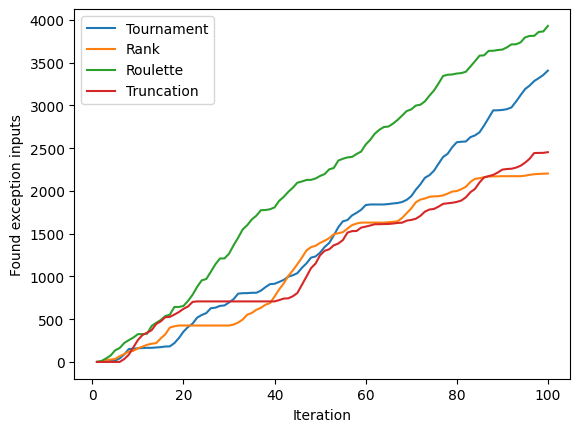

Area under Tournament: 143146.0
Area under Rank: 119033.0
Area under Roulette: 208944.5
Area under Truncation: 120565.0


In [8]:
import matplotlib.pyplot as plt
from numpy import trapz
xt = [a[0] for a in test_tournament]
yt = [a[1] for a in test_tournament]
plt.plot(xt, yt, label='Tournament')

xr = [a[0] for a in test_rank]
yr = [a[1] for a in test_rank]
plt.plot(xr, yr, label='Rank')

xrw = [a[0] for a in test_roulette]
yrw = [a[1] for a in test_roulette]
plt.plot(xrw, yrw, label='Roulette')

xtn = [a[0] for a in test_truncation]
ytn = [a[1] for a in test_truncation]
plt.plot(xtn, ytn, label='Truncation')

plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Found exception inputs')
plt.show()

area_t = trapz(yt, dx=1)
area_r = trapz(yr, dx=1)
area_rw = trapz(yrw, dx=1)
area_tn = trapz(ytn, dx=1)

print(f"Area under Tournament: {area_t}")
print(f"Area under Rank: {area_r}")
print(f"Area under Roulette: {area_rw}")
print(f"Area under Truncation: {area_tn}")

## Using a different fitness function

For instance, suppose we're interested in inputs that invoke the cosine function in our calculator. We could define a fitness function `fitness_function_cos` that assigns a high fitness value to inputs containing 'cos'. (**Note that this might not be the best fitness function to find new expcetions.**)

In [9]:
from evogfuzz.input import Input

def fitness_function_cos(inp: Input) -> float:
    if 'cos' in str(inp):
        return 1.0
    else:
        return 0.0

Once your fitness function is defined, you can incorporate it into the `EvoGFuzz` instance by passing it as the `fitness_function` argument. 

In [10]:
from evogfuzz.evogfuzz_class import Strategy
import matplotlib.pyplot as plt
from numpy import trapz
epp = EvoGFuzz(
    grammar=CALCGRAMMAR,
    oracle=oracle,
    inputs=initial_inputs,
    fitness_function=fitness_function_cos,
    iterations=100,
    strategy=Strategy.TOURNAMENT
)

found_exception_inputs = epp.fuzz()
test_tournament = epp.get_benchmark()

epp = EvoGFuzz(
    grammar=CALCGRAMMAR,
    oracle=oracle,
    inputs=initial_inputs,
    fitness_function=fitness_function_cos,
    iterations=100,
    strategy=Strategy.RANK
)

found_exception_inputs = epp.fuzz()
test_rank = epp.get_benchmark()

epp = EvoGFuzz(
    grammar=CALCGRAMMAR,
    oracle=oracle,
    inputs=initial_inputs,
    fitness_function=fitness_function_cos,
    iterations=100,
    strategy=Strategy.TRUNCATION,
)

found_exception_inputs = epp.fuzz()
test_truncation = epp.get_benchmark()



epp = EvoGFuzz(
    grammar=CALCGRAMMAR,
    oracle=oracle,
    inputs=initial_inputs,
    fitness_function=fitness_function_cos,
    iterations=100,
    strategy=Strategy.ROULETTE
)

found_exception_inputs = epp.fuzz()
test_roulette = epp.get_benchmark()

Now plot our results for the custom fitness function:

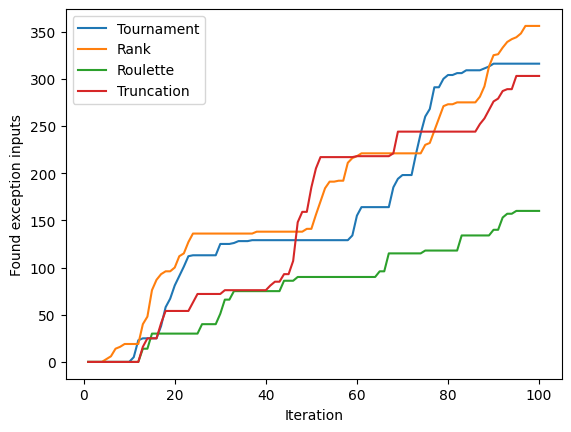

Area under Tournament: 15758.0
Area under Rank: 17470.0
Area under Roulette: 8025.0
Area under Truncation: 15067.5


In [11]:
xt = [a[0] for a in test_tournament]
yt = [a[1] for a in test_tournament]
plt.plot(xt, yt, label='Tournament')

xr = [a[0] for a in test_rank]
yr = [a[1] for a in test_rank]
plt.plot(xr, yr, label='Rank')

xrw = [a[0] for a in test_roulette]
yrw = [a[1] for a in test_roulette]
plt.plot(xrw, yrw, label='Roulette')

xtn = [a[0] for a in test_truncation]
ytn = [a[1] for a in test_truncation]
plt.plot(xtn, ytn, label='Truncation')

plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Found exception inputs')
plt.show()

area_t = trapz(yt, dx=1)
area_r = trapz(yr, dx=1)
area_rw = trapz(yrw, dx=1)
area_tn = trapz(ytn, dx=1)

print(f"Area under Tournament: {area_t}")
print(f"Area under Rank: {area_r}")
print(f"Area under Roulette: {area_rw}")
print(f"Area under Truncation: {area_tn}")

## Testing different Programs

Here, we demonstrate how to test multiple programs from the debugging-benchmark repository using the default tournament selection.

In [12]:
from typing import List

from debugging_framework.benchmark.program import BenchmarkProgram

from debugging_benchmark.calculator.calculator import CalculatorBenchmarkRepository
from debugging_benchmark.middle.middle import MiddleBenchmarkRepository
from debugging_benchmark.expression.expression import ExpressionBenchmarkRepository
from debugging_benchmark.markup.markup import MarkupBenchmarkRepository
from debugging_benchmark.tests4py_benchmark.repository import CookieCutterBenchmarkRepository
from debugging_benchmark.tests4py_benchmark.repository import PysnooperBenchmarkRepository

repo_subjects: List[BenchmarkProgram] = MiddleBenchmarkRepository().build()
subject: BenchmarkProgram = repo_subjects[0]
oracle = subject.get_oracle()
grammar = subject.get_grammar()

from typing import List
from debugging_framework.benchmark.repository import BenchmarkRepository

repos: List[BenchmarkRepository] = [
    #PysnooperBenchmarkRepository(), #TODO: fix
    #CookieCutterBenchmarkRepository(),
    CalculatorBenchmarkRepository(),
    MiddleBenchmarkRepository(),
    ExpressionBenchmarkRepository(),
    MarkupBenchmarkRepository(),
]

from debugging_framework.benchmark.program import BenchmarkProgram

subjects: List[BenchmarkProgram] = []
for repo in repos:
    for prog in repo.build():
        subjects.append(prog)

subject = subjects[0]

Once again, we plot our results.

In [13]:

for s in subjects:
    print(s)
print(subjects[2])

CalculatorCalculator_1
BenchmarkProgram(middle)
BenchmarkProgram(expression)
BenchmarkProgram(markup)
BenchmarkProgram(expression)


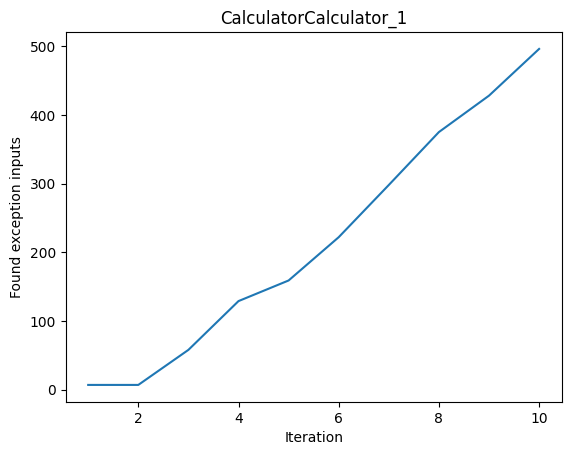

Area under Curve: 1927.5


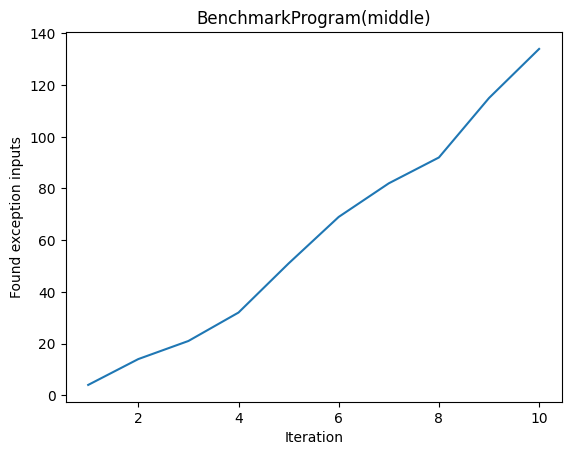

Area under Curve: 545.0


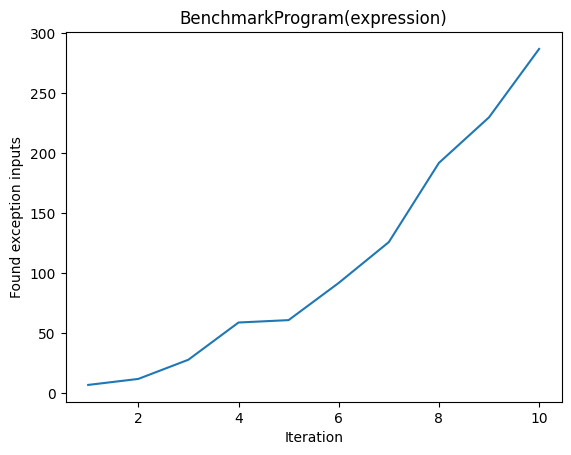

Area under Curve: 947.0


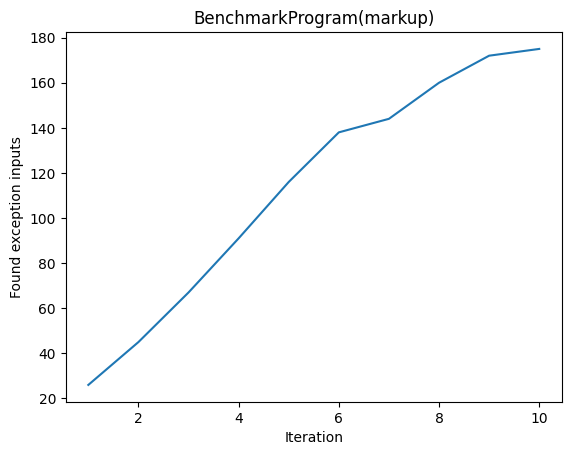

Area under Curve: 1033.5


In [14]:
for s in subjects:
    epp = EvoGFuzz(
    grammar=s.get_grammar(),
    oracle=s.get_oracle(),
    inputs=s.get_initial_inputs(),
    iterations=10
    )
    found_exception_inputs = epp.fuzz()
    test = epp.get_benchmark()

    x = [a[0] for a in test]
    y = [a[1] for a in test]
    plt.plot(x, y)
    plt.title(s)
    plt.xlabel('Iteration')
    plt.ylabel('Found exception inputs')
    plt.show()
    area = trapz(y, dx=1)
    print(f"Area under Curve: {area}")

## TODO: test all programs using all selections strategies and 30 trails

During our experiment, we save the data as a pandas data frame to then store it as a .csv file.

In [15]:
subj = subjects[0]
print(subj.get_grammar())
print(subj.get_initial_inputs())

{'<start>': ['<config>\n<hooks>'], '<config>': ['{<full_name>,<email>,<github_username>,<project_name>,<repo_name>,<project_short_description>,<release_date>,<year>,<version>}'], '<hooks>': ['', '<hook_list>'], '<hook_list>': ['<hook>', '<hook_list>\n<hook>'], '<hook>': ['<pre_hook>', '<post_hook>'], '<pre_hook>': ['pre:<hook_content>'], '<post_hook>': ['post:<hook_content>'], '<hook_content>': ['echo,<str_with_spaces>', 'exit,<int>'], '<full_name>': ['"full_name":"<str_with_spaces>"', '"full_name":[<str_with_spaces_list>]'], '<email>': ['"email":"<email_address>"', '"email":[<email_list>]'], '<github_username>': ['"github_username":"<str>"', '"github_username":[<str_list>]'], '<project_name>': ['"project_name":"<str_with_spaces>"', '"project_name":[<str_with_spaces_list>]'], '<repo_name>': ['"repo_name":"<str>"', '"repo_name":[<str_list>]'], '<project_short_description>': ['"project_short_description":"<str_with_spaces>"', '"project_short_description":[<str_with_spaces_list>]'], '<rel

In [18]:
import pandas as pd
strategies = {Strategy.TOURNAMENT, Strategy.RANK, Strategy.ROULETTE, Strategy.TRUNCATION}
runs = 30 # 30 
it = 100 # 100


eval_data = {}
for s in subjects:
    eval_data[s] = {}
    for strat in strategies:
        eval_data[s][strat] = []
        benchmark_run = []
        for _ in range(runs):
            epp = EvoGFuzz(
            grammar=s.get_grammar(),
            oracle=s.get_oracle(),
            inputs=s.get_initial_inputs(),
            iterations=it,
            strategy=strat
            )
            found_exception_inputs = epp.fuzz()
            test = epp.get_benchmark()
            benchmark_run.append(test)
        eval_data[s][strat] = benchmark_run
df = pd.DataFrame(data=eval_data)
#df.to_csv('out.csv', encoding='utf-8')

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f3d5ded9010>>
Traceback (most recent call last):
  File "/home/daniel/SE2/evogfuzzplusplus-selection-strategies/.conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

  File "/home/daniel/SE2/evogfuzzplusplus-selection-strategies/.conda/lib/python3.11/site-packages/debugging_framework/execution/timeout_manager.py", line 18, in alarm_handler
    raise TimeoutError("Function call timed out")
TimeoutError: Function call timed out
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f3d5ded9010>>
Traceback (most recent call last):
  File "/home/daniel/SE2/evogfuzzplusplus-selection-strategies/.conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_t

In [17]:
#df.to_csv('out.csv', encoding='utf-8')

In [19]:
for s in subjects:
    asdf = df[s]
    print(s)
    for strat in strategies:
        print(strat)
        asd = asdf[strat]
        for i in range(len(asd)):
            print (asd[i])

CalculatorCalculator_1
Tournament
[(1, 7), (2, 8), (3, 55), (4, 93), (5, 163), (6, 227), (7, 299), (8, 390), (9, 464), (10, 555), (11, 637), (12, 663), (13, 683), (14, 751), (15, 850), (16, 949), (17, 1049), (18, 1122), (19, 1180), (20, 1206), (21, 1267), (22, 1275), (23, 1283), (24, 1307), (25, 1326), (26, 1384), (27, 1385), (28, 1389), (29, 1402), (30, 1442), (31, 1504), (32, 1510), (33, 1522), (34, 1557), (35, 1603), (36, 1646), (37, 1678), (38, 1709), (39, 1747), (40, 1821), (41, 1879), (42, 1922), (43, 1971), (44, 2020), (45, 2086), (46, 2114), (47, 2155), (48, 2187), (49, 2245), (50, 2295), (51, 2351), (52, 2361), (53, 2390), (54, 2440), (55, 2493), (56, 2537), (57, 2548), (58, 2561), (59, 2585), (60, 2590), (61, 2611), (62, 2639), (63, 2726), (64, 2726), (65, 2741), (66, 2755), (67, 2772), (68, 2837), (69, 2919), (70, 2978), (71, 3036), (72, 3071), (73, 3090), (74, 3131), (75, 3203), (76, 3272), (77, 3333), (78, 3342), (79, 3362), (80, 3427), (81, 3447), (82, 3513), (83, 3604), 

CalculatorCalculator_1
Tournament
Roulette
Rank
Truncation


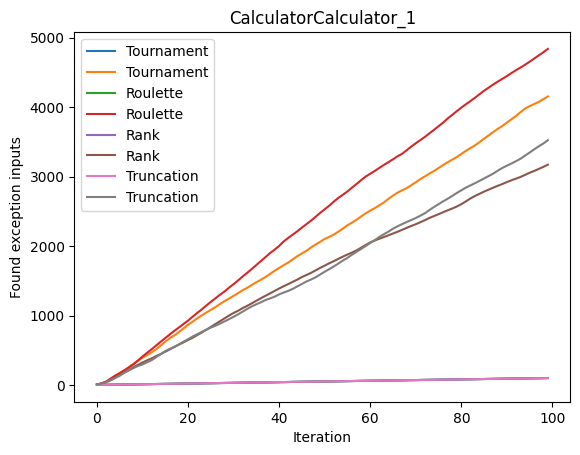

BenchmarkProgram(middle)
Tournament
Roulette
Rank
Truncation


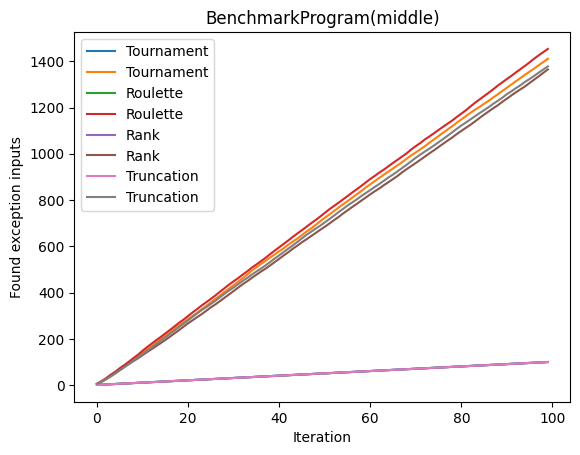

BenchmarkProgram(expression)
Tournament
Roulette
Rank
Truncation


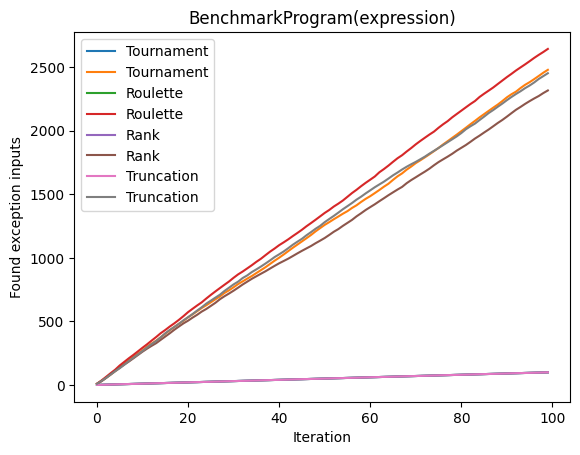

BenchmarkProgram(markup)
Tournament
Roulette
Rank
Truncation


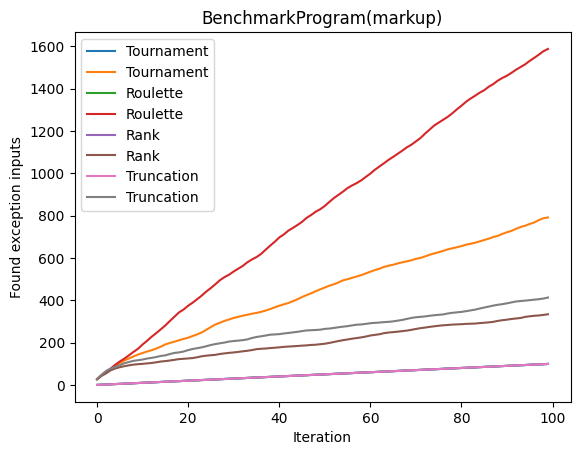

In [46]:
#CalculatorCalculator_1
#BenchmarkProgram(middle)
#BenchmarkProgram(expression)
#BenchmarkProgram(markup)
#BenchmarkProgram(expression)
import numpy as np
for k in df.keys():
    a = df[k]
    for l in a.keys():
        b = a[l]
        means = np.mean(b, axis=0)
        plt.plot(means, label=l)
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Found exception inputs')
    plt.title(k)
    plt.show()
        
            
      

In [45]:
xval

array([ 1.        , 28.46666667])

In [ ]:

xt = [a[0] for a in test_tournament]
yt = [a[1] for a in test_tournament]
plt.plot(xt, yt, label='Tournament')

xr = [a[0] for a in test_rank]
yr = [a[1] for a in test_rank]
plt.plot(xr, yr, label='Rank')

xrw = [a[0] for a in test_roulette]
yrw = [a[1] for a in test_roulette]
plt.plot(xrw, yrw, label='Roulette')

xtn = [a[0] for a in test_truncation]
ytn = [a[1] for a in test_truncation]
plt.plot(xtn, ytn, label='Truncation')

plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Found exception inputs')
plt.show()

area_t = trapz(yt, dx=1)
area_r = trapz(yr, dx=1)
area_rw = trapz(yrw, dx=1)
area_tn = trapz(ytn, dx=1)

print(f"Area under Tournament: {area_t}")
print(f"Area under Rank: {area_r}")
print(f"Area under Roulette: {area_rw}")
print(f"Area under Truncation: {area_tn}")